<a href="https://colab.research.google.com/github/jmellafe/question_deduplication/blob/master/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.matutils import sparse2full
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# import data from the drive 

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_path = '/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/data/train.csv' #change dir to your project folder

ImportError: ignored

In [0]:
# Hend data importing cell 

df = pd.read_csv('/content/gdrive/My Drive/KTH courses/P4/NLP Language processing/project/data/train.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
#Alex data importing cell

# df = pd.read_csv('/content/gdrive/My Drive/project/data/train.csv')
df = pd.read_csv('/home/slimbook/PycharmProjects/question_deduplication/data/train.csv') #local

df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
# Shuffle the data

df = df.sample(frac=1, random_state = 0).reset_index(drop=True)

# Create train, validation and test datasets
train_portion = 0.7
val_portion = 0.15
test_portion = 0.15

train_idx = int(train_portion * df.shape[0])
val_idx = int((train_portion + val_portion) * df.shape[0])

train = df[:train_idx]
val = df[train_idx:val_idx]
test = df[val_idx:]

Class 0:  178510  Class1:  104493


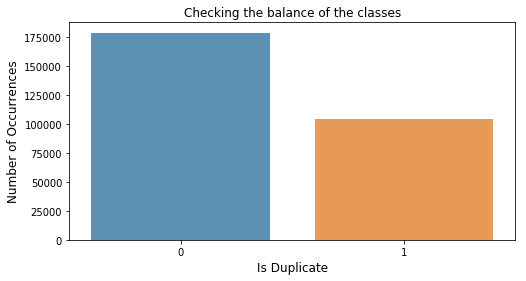

In [5]:
is_dup = train['is_duplicate'].value_counts()
print("Class 0: ", is_dup[0], " Class1: ", is_dup[1])
plt.figure(figsize=(8,4))
sns.barplot(is_dup.index, is_dup.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Is Duplicate', fontsize=12)
plt.title('Checking the balance of the classes')
plt.show()

In [0]:
# cleaning and balancing the training set
train = train.dropna().reset_index(drop=True)

class0 = train[train['is_duplicate']==0].sample(n=is_dup[1], random_state=1)
class1 = train[train['is_duplicate']==1]
train = pd.concat([class0, class1])


No handles with labels found to put in legend.


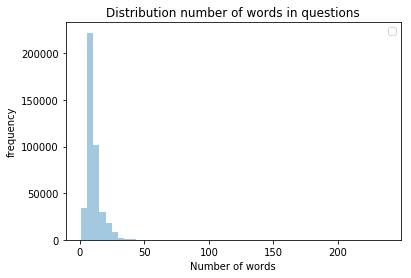

<Figure size 432x288 with 0 Axes>

In [7]:

# HIstogram number of words

temp = train['question1'].apply(lambda x: len(x.split()) if type(x) == str else np.nan)

temp2 = train['question2'].apply(lambda x: len(x.split()) if type(x) == str else np.nan)

temp = pd.concat([temp, temp2]).dropna()

sns.distplot(temp, kde=False)
plt.legend()
plt.title("Distribution number of words in questions")
plt.xlabel("Number of words")
plt.ylabel("frequency")

plt.show()
plt.clf()


No handles with labels found to put in legend.


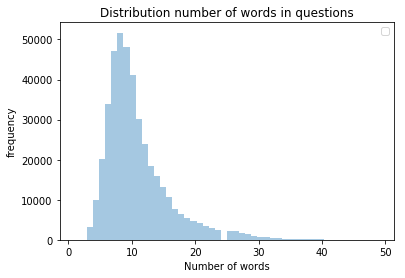

<Figure size 432x288 with 0 Axes>

In [8]:
# detail same plot
sns.distplot(temp[temp < 50], kde=False)
plt.legend()
plt.title("Distribution number of words in questions")
plt.xlabel("Number of words")
plt.ylabel("frequency")

plt.show()
plt.clf()

## Preprocessing and preparing Features

In [9]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/slimbook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
# simple tokenization just to build the tf-idf feature vector, probably we should replace it for something fancier
train['q1_tokens'] = train['question1'].apply(lambda x: word_tokenize(x) if type(x)==str else np.nan)
train['q2_tokens'] = train['question2'].apply(lambda x: word_tokenize(x) if type(x)==str else np.nan)

val['q1_tokens'] = val['question1'].apply(lambda x: word_tokenize(x) if type(x)==str else np.nan)
val['q2_tokens'] = val['question2'].apply(lambda x: word_tokenize(x) if type(x)==str else np.nan)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [11]:
# delete stopwords
nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('english'))
train['q1_tokens'] = train['q1_tokens'].apply(lambda x: [w for w in x if w not in STOP_WORDS])
train['q2_tokens'] = train['q2_tokens'].apply(lambda x: [w for w in x if w not in STOP_WORDS])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/slimbook/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Create gensim dictionary to allow BoW representation
dctr = Dictionary(train['q1_tokens'].dropna())
dctr.add_documents(train['q2_tokens'].dropna())

# Create tf-idf model
corpus = train['q1_tokens'].tolist() + train['q2_tokens'].tolist()
corpus = [dctr.doc2bow(sent) for sent in corpus if type(sent)==list]
model = TfidfModel(corpus)

# Apply tf-idf to all the questions in the training set, creating new columns
train['q1_tfidf'] = train['q1_tokens'].apply(lambda x: model[dctr.doc2bow(x)] if type(x)==list else np.nan)
train['q2_tfidf'] = train['q2_tokens'].apply(lambda x: model[dctr.doc2bow(x)] if type(x)==list else np.nan)

train.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_tokens,q2_tokens,q1_tfidf,q2_tfidf
31152,395916,528943,499737,What is absolute black?,What is absolution?,0,"[What, absolute, black, ?]","[What, absolution, ?]","[(0, 0.00012110610473031244), (1, 0.1051982067...","[(0, 9.27165384396753e-05), (1, 0.080537753255..."
149379,76666,131026,131027,Why did AOL buy Time Warner?,Why is AT&T buying Time Warner?,0,"[Why, AOL, buy, Time, Warner, ?]","[Why, AT, &, T, buying, Time, Warner, ?]","[(0, 6.750163191519274e-05), (4, 0.58099605812...","[(0, 5.9131578717069275e-05), (5, 0.4163507112..."
69891,195287,295691,295692,Can I wear shades at night?,What is the fee structure of SIHMA for BHM?,0,"[Can, I, wear, shades, night, ?]","[What, fee, structure, SIHMA, BHM, ?]","[(0, 7.975160080421212e-05), (9, 0.24303586775...","[(0, 5.505150372576836e-05), (1, 0.04782021091..."
209637,38317,69610,69611,How can one understand the meaning of life?,How do you realize what is really important in...,0,"[How, one, understand, meaning, life, ?]","[How, realize, really, important, life, ?]","[(0, 0.00011102533568057859), (14, 0.133744601...","[(0, 0.00010019388368544854), (14, 0.120696694..."
164367,36517,66573,66574,How can the coking happen on a load tap changer?,Any one experienced on marketing live streamin...,0,"[How, coking, happen, load, tap, changer, ?]","[Any, one, experienced, marketing, live, strea...","[(0, 5.35184650344882e-05), (14, 0.06447002153...","[(0, 3.882550689915528e-05), (17, 0.1300074178..."


In [42]:
# preparing the features 

# Similarities
def sim_tfidf(a, b):
  
  max_idx = max([w[0] for w in a] + [w[0] for w in b])+1
  
  a_vec = np.zeros(max_idx)
  b_vec = np.zeros(max_idx)
  
  for w in a:
    a_vec[w[0]] = w[-1]
    
  for w in b:
    b_vec[w[0]] = w[-1]
    
  return cosine_similarity(a_vec.reshape(1,-1),b_vec.reshape(1,-1))



#series of all the questions in the training set 
train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)
print("Question: ",train_qs[1])

#length of the questions provided in the train set
len_qs_train = train_qs.apply(lambda x: len(x.split(' ')))
print("lengh of the question: ",len_qs_train[1])

qmarks = train_qs.apply(lambda x: '?' in x)
print("The pourcentage of questions including '?' : ",np.mean(qmarks))

fullstop = train_qs.apply(lambda x: '.' in x)
print("The pourcentage of questions including '.' : ",np.mean(fullstop))

capital_first = train_qs.apply(lambda x: x[0].isupper())
print("The pourcentage of questions starting with a capital letter is: ",np.mean(capital_first))

capitals = train_qs.apply(lambda x: max([y.isupper() for y in x]))
print("The pourcentage of questions including capital letters : ",np.mean(capitals))

numbers = train_qs.apply(lambda x: max([y.isdigit() for y in x]))
print("The mean max numbers of digits in  of questions including numbers : ",np.mean(numbers))

similarities = np.array([sim_tfidf(a,b) for a,b in zip(train['q1_tfidf'].tolist(), train['q2_tfidf'].tolist())])
print("The mean similarity the question pairs is : ",np.mean(numbers))
stat_features = [len_qs_train, qmarks, fullstop, capital_first, capitals, numbers, similarities]

Question:  Is Roambi a big data app startup? What is the technology behind it?
lengh of the question:  13
The pourcentage of questions including '?' :  0.9988611677337238
The pourcentage of questions including '.' :  0.056278889494990096
The pourcentage of questions starting with a capital letter is:  0.9983204616577187
The pourcentage of questions including capital letters :  0.9995645641334826
The mean max numbers of digits in  of questions including numbers :  0.11633075899821041
The mean similarity the question pairs is :  0.11633075899821041


NameError: ignored

In [46]:
# tfidf dimensionality reduction

def tfidf_to_array(tfidf_list, len_dict):
  tfidf_array = np.zeros(len_dict)
  tfidf_array[[w[0] for w in tfidf_list]] = [w[-1] for w in tfidf_list]
  return tfidf_array
  
all_vecs = pd.concat([train['q1_tfidf'][1000].apply(lambda x:sparse2full(x, len(dctr))),train['q2_tfidf'][1000].apply(lambda x:sparse2full(x, len(dctr)))])

KeyboardInterrupt: ignored

# **Deep model Alex**

In [10]:
from keras.models import Model
from keras.layers.recurrent import GRU
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense
from keras.layers import Dropout, Flatten
import keras


def define_network():

    gru_shared_layer = GRU(300, dropout = 0.2, recurrent_dropout = 0.2, name = 'GRU_common')

    input_1 = Input((None, 300), name = 'q1_input') # Input question 1
    input_2 = Input((None, 300), name = 'q2_input') # Input question 2

    gru_1 = gru_shared_layer(input_1)
    gru_2 = gru_shared_layer(input_2)

    merge = keras.layers.merge.concatenate([gru_1, gru_2])
    
    bn = BatchNormalization()(merge)
    dense = Dense(300, activation = 'relu', name = "relu_dense")(bn)
    drop = Dropout(0.2)(dense)
    bn2 = BatchNormalization()(drop)
    output = Dense(1, activation = 'sigmoid', name = 'output_dense')(bn2)


    model = Model(inputs = [input_1, input_2], outputs = output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model
  

Using TensorFlow backend.


In [0]:

import pymagnitude as mag

embedder = mag.Magnitude('/home/slimbook/PycharmProjects/question_deduplication/data/glove.6B.300d.magnitude') #local

# batch generator, embedding the sentences

def batch_generator(q1_list, q2_list, match_list, embedder, batch_size = 32):
  while True:

    l = len(q1_list)

    for idx in range(0, l, batch_size):

      yield [embedder.query(q1_list[idx:min(idx + batch_size, l)]), embedder.query(q2_list[idx:min(idx + batch_size, l)])], (np.array(match_list[idx:min(l, idx + batch_size)])==1).astype('float32').reshape(-1, 1)

train = train.sample(frac=1).reset_index(drop=True)

q1_list = train['q1_tokens'].tolist()
q2_list = train['q2_tokens'].tolist()
match_list = train['is_duplicate'].tolist()

q1_val_list = val['q1_tokens'].tolist()
q2_val_list = val['q2_tokens'].tolist()
match_val_list = val['is_duplicate'].tolist()
    
batch_size = 32
num_batches_per_epoch_train = len(q1_list)//batch_size+1
num_batches_per_epoch_val = len(q1_val_list)//batch_size+1

In [0]:
batch = [i for i in batch_generator(q1_list, q2_list, match_list, embedder, batch_size)]


In [21]:
len(batch), num_batches_per_epoch_train

(32, 32)

In [25]:
model = define_network()

model.summary()

history = model.fit_generator(
    generator = batch_generator(q1_list, q2_list, match_list, embedder, batch_size),
    steps_per_epoch = num_batches_per_epoch_train,
    validation_data = batch_generator(q1_val_list, q2_val_list, match_val_list, embedder, batch_size),
    validation_steps = num_batches_per_epoch_val,
    epochs = 4,
    use_multiprocessing=True,
    verbose = 2
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
q1_input (InputLayer)           (None, None, 300)    0                                            
__________________________________________________________________________________________________
q2_input (InputLayer)           (None, None, 300)    0                                            
__________________________________________________________________________________________________
GRU_common (GRU)                (None, 300)          540900      q1_input[0][0]                   
                                                                 q2_input[0][0]                   
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 600)          0           GRU_common[0][0]                 
          

In [15]:
5 // 2

2